Let's go.

In [71]:
import pandas as pd

In [72]:
def openData():
    df=pd.read_csv("../data.csv")
    df.drop_duplicates()
    return df
df=openData()
df=df.drop(['district','test'],axis=1)
df=df.dropna(subset=['price'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   meter                 5186 non-null   int64  
 1   buildYear             5186 non-null   int64  
 2   rooms                 5186 non-null   int64  
 3   price                 5186 non-null   int64  
 4   elevator              5186 non-null   int64  
 5   space                 5186 non-null   int64  
 6   parking               5186 non-null   int64  
 7   floor                 5186 non-null   int64  
 8   averageDistrictValue  5186 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 364.8 KB


just working a bit with the dataset to understand what's going on. you can pass this.

In [73]:
print(df.describe())

               meter     buildYear        rooms         price     elevator  \
count    5186.000000   5186.000000  5186.000000  5.186000e+03  5186.000000   
mean      183.359429   1394.533166     1.897609  1.153036e+10     0.731778   
std      4172.625938    173.926991     0.756410  1.672674e+10     0.443077   
min        19.000000   1370.000000     0.000000  0.000000e+00     0.000000   
25%        59.000000   1385.000000     1.000000  3.270000e+09     0.000000   
50%        80.000000   1393.000000     2.000000  6.000000e+09     1.000000   
75%       114.000000   1400.000000     2.000000  1.300000e+10     1.000000   
max    270000.000000  13902.000000     4.000000  2.400000e+11     1.000000   

             space      parking        floor  averageDistrictValue  
count  5186.000000  5186.000000  5186.000000          5.186000e+03  
mean      0.762630     0.858851     3.012341          9.906873e+07  
std       0.425512     0.348209     2.359462          5.894089e+07  
min       0.000000   

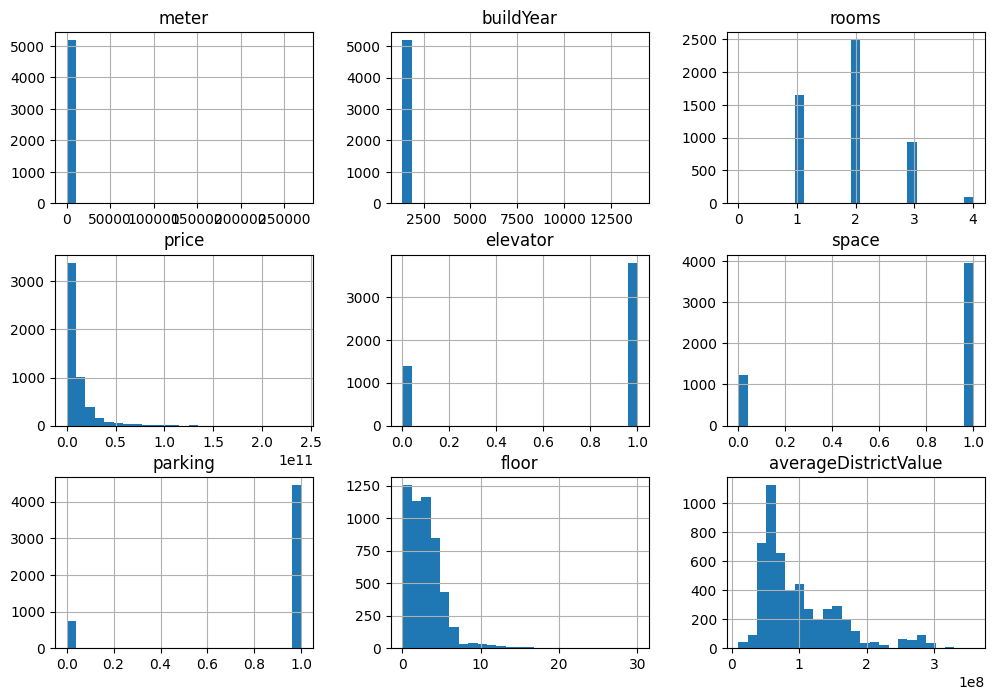

In [74]:
import matplotlib.pyplot as plt
df.hist(bins=25, figsize=(12, 8))
plt.show()

**Deleting the outliers**

In [75]:
import numpy as np
from scipy import stats
outlierHigh = df["price"].quantile(0.99)
outlierLow = df["price"].quantile(0.02)
df.reset_index()
df=df[(df['price'] > outlierLow) & (df['price'] < outlierHigh)]
print(outlierLow,outlierHigh)
df['price'].count

1690000000.0 71054000000.00009


<bound method Series.count of 0        2450000000
1        2600000000
2        3500000000
3        6800000000
4        3480000000
           ...     
5181    14300000000
5182     9880000000
5183     8500000000
5184     4200000000
5185     6450000000
Name: price, Length: 4950, dtype: int64>

**making the test set**

In [76]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [77]:
house_with_id = df.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

count      4950.000000
mean        184.621414
std        4270.822625
min          20.000000
25%          59.000000
50%          80.000000
75%         112.000000
max      270000.000000
Name: meter, dtype: float64


Text(0, 0.5, 'Number of districts')

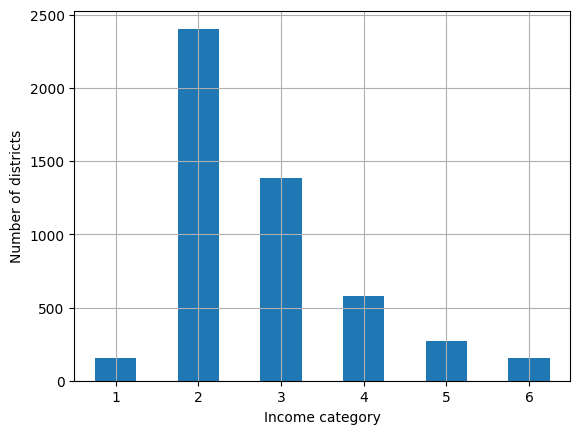

In [78]:
print(df['meter'].describe())
df["meter_cat"] = pd.cut(df["meter"].astype(float),
bins=[0., 40, 80, 120, 160, 200., np.inf],
labels=[1, 2, 3, 4, 5, 6])
df["meter_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(df, df["meter_cat"]):
    stratTrainSetN = df.iloc[trainIndex]
    stratTestSetN = df.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]

In [80]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("meter_cat", axis=1 , inplace=True)

/tmp/ipykernel_10711/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)
/tmp/ipykernel_10711/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [81]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price                   1.000000
averageDistrictValue    0.771718
rooms                   0.660726
space                   0.336613
elevator                0.322263
parking                 0.205688
floor                   0.167512
meter                   0.096034
buildYear              -0.002072
Name: price, dtype: float64


_note 1_ : wow it seems that meter is really important!

In [82]:

print(stratTrainSet.describe())
house = stratTrainSet.drop('price',axis=1)
labels = stratTrainSet[['price']].copy()
print(labels.describe())

               meter     buildYear        rooms         price     elevator  \
count    3960.000000   3960.000000  3960.000000  3.960000e+03  3960.000000   
mean      184.173737   1395.090152     1.882576  1.040744e+10     0.731818   
std      4538.597911    198.977055     0.736313  1.098966e+10     0.443069   
min        26.000000   1370.000000     0.000000  1.700000e+09     0.000000   
25%        59.000000   1385.000000     1.000000  3.400000e+09     0.000000   
50%        80.000000   1393.000000     2.000000  6.200000e+09     1.000000   
75%       112.000000   1400.000000     2.000000  1.300000e+10     1.000000   
max    270000.000000  13902.000000     4.000000  7.100000e+10     1.000000   

             space      parking        floor  averageDistrictValue  
count  3960.000000  3960.000000  3960.000000          3.960000e+03  
mean      0.760859     0.861869     2.914394          9.872586e+07  
std       0.426613     0.345081     2.107252          5.671532e+07  
min       0.000000   

imputation

In [83]:
def imputeFrequent(cols,h):
    for col in cols:
        frequent = house[col].mode()
        h[[col]]=h[[col]].fillna(float(frequent),inplace=False)
    return h
house = imputeFrequent(['floor','rooms','meter','buildYear'], house)
house.describe()


,meter,buildYear,rooms,elevator,space,parking,floor,averageDistrictValue
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3.960000e+03
mean,184.173737,1395.090152,1.882576,0.731818,0.760859,0.861869,2.914394,9.872586e+07
std,4538.597911,198.977055,0.736313,0.443069,0.426613,0.345081,2.107252,5.671532e+07
min,26.000000,1370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.539284e+06
25%,59.000000,1385.000000,1.000000,0.000000,1.000000,1.000000,2.000000,5.956366e+07
50%,80.000000,1393.000000,2.000000,1.000000,1.000000,1.000000,3.000000,7.826752e+07
75%,112.000000,1400.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.306493e+08
max,270000.000000,13902.000000,4.000000,1.000000,1.000000,1.000000,30.000000,3.581995e+08


*Handling district*

number attributes:

In [84]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
houseNum=house.select_dtypes(np.number)
housingNumStd = std_scaler.fit_transform(houseNum)

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(house[["meter"]])

**And finally The PIPELINE**

In [85]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
("impute", SimpleImputer(strategy='most_frequent')),
("standardize", StandardScaler()),
])
houseNumPrepared=num_pipeline.fit_transform(houseNum)
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"))

preprocessing = ColumnTransformer([
],remainder=num_pipeline)
housing_prepared = preprocessing.fit_transform(house)


**Train**

**Really, Really Testing for overfitting**

In [86]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=4))
print(sklearn.metrics.get_scorer_names())
forest_mae = -cross_val_score(forest_reg, house, labels['price'],cv=7,scoring="neg_mean_absolute_error")
forest_rmse = -cross_val_score(forest_reg, house, labels['price'],cv=7,scoring="neg_mean_squared_error")

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [87]:
from math import sqrt
print(sqrt(forest_rmse.mean())/1e9,forest_rmse.std())
print(forest_mae.mean()/1e9,forest_mae.std())
print(type(labels['price']))
forest_reg.fit(house,labels['price'])
housing_predictions = forest_reg.predict(house)
print(housing_predictions[:5]/1e9)
print(labels['price'][:5]/1e9)


3.477169883126074 5.008443853763858e+18
1.658023483046171 162103196.78387818
<class 'pandas.core.series.Series'>
[22.85688  2.59595 63.772   12.88175 12.5095 ]
1152    22.120
4467     2.625
1245    66.000
2974    13.000
4029    12.400
Name: price, dtype: float64
